# Notebook for detecting multi-resolution clonal structures with Wave-LSTM

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [124]:
import umap
import numpy as np
import pickle as pkl
import torch
import pandas as pd
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style, colors
import palettable
from palettable.colorbrewer.qualitative import Set1_6 as pallette
# from hydra import compose, initialize
from omegaconf import OmegaConf
import omegaconf
import pytorch_lightning as pl
import wandb

import os
from pathlib import Path
import sys
node_type = os.getenv('BB_CPU')
venv_dir = f'/rds/homes/g/gaddcz/Projects/waveletVAE/my-virtual-env-{node_type}'  # edit this line to match the venv directory format
venv_site_pkgs = Path(venv_dir) / 'lib' / f'python{sys.version_info.major}.{sys.version_info.minor}' / 'site-packages'
if venv_site_pkgs.exists():
    sys.path.insert(0, str(venv_site_pkgs))
    print(f"Loaded venv for {node_type}")
else:
    print(f"Path '{venv_site_pkgs}' not found. Check that it exists and/or that it exists for node-type '{node_type}'.")

%load_ext autoreload
%autoreload 2

Path '/rds/homes/g/gaddcz/Projects/waveletVAE/my-virtual-env-None/lib/python3.8/site-packages' not found. Check that it exists and/or that it exists for node-type 'None'.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
# !pip install ptwt
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('./'), '../../../')))
from src.TCGA.data_modules.CHISEL_S0E.loaders import DataModule, Dataset, LoadCHISEL_S0E
from sklearn import preprocessing
from src.WaveLSTM.custom_callbacks.waveLSTM import SaveOutput
# from src.WaveLSTM.models.base import WaveletBase as SourceSeparation
from src.WaveLSTM.models.attentive_autoencoder import create_sa_autoencoder, AttentiveAutoEncoder

# Plotting set up
sns.set()
sns.set_palette(pallette.mpl_colors)
cmap = plt.cm.Blues
norm = colors.BoundaryNorm(np.arange(-0.5, 8.5, 1), cmap.N)

# turn off wandb to avoid updating project
wandb.init(mode="disabled")

%matplotlib inline


In [126]:
def stack_batches(dataloader):
    # Stack all test data for test hook
    CNA, labels = [], []
    for batch in iter(dataloader()):
        CNA.append(batch["CNA"])
        labels.append(batch["label"])
    return {"CNA": torch.concat(CNA, 0),
            "label": torch.concat(labels, 0),
            }

# Load default configuration

In [127]:
## Get config
# with initialize(version_base=None, config_path="../confs", job_name="chisel_ae_inference"):
#     config = compose(config_name="autoencoder_config.yaml")

config = "../confs/autoencoder_config.yaml"


# Choose which seed checkpoint to load
stack = True
if not stack:
    config.data.stack = False
    config.encoder.waveLSTM.J = 5
    checkpoint = "waveLSTM_h256_p64_stackFalse"
else:
    checkpoint = "cnn_h256_p64_stackTrue"

config = OmegaConf.load(config)
OmegaConf.set_struct(config, False)

# print(OmegaConf.to_yaml(config))

# Get data

In [128]:
# Load data
pl.seed_everything(42)
dm = DataModule(**config.data)

le = dm.train_set.label_encoder
labels = le.classes_
classes = len(le.classes_)
channels = 2 if stack is True else 44
W = 256 * channels

Global seed set to 42


In [129]:
# display(dm.train_set.data_frame)
print(labels)

loader = LoadCHISEL_S0E()
display(loader.data_frame.head())

# import pandas as pd
# data = pd.read_csv("/home/dashuo/idun/remote/waveLSTM/src/TCGA/data_modules/CHISEL_S0E/data/merged.csv", index_col="CELL", usecols=[i for i in range(1,14)])
# display(data.dropna().head())

# display(type(data["CLONE"].unique()[1]))
# display(type(np.nan))

['Clone5' 'Clone63' 'Clone156' 'Clone172' 'Clone199' 'Clone241' 'None']


,X.CHR,START,END,NORM_COUNT,COUNT,RDR,A_COUNT,B_COUNT,BAF,CLUSTER,CN_STATE,CLONE
CELL,,,,,,,,,,,,
AAACCTGCACCAAAGG,chr1,0,5000000,2654972,547,0.801010,14,23,0.621622,3,1|2,Clone199
AAACCTGCAGGACCAA,chr1,0,5000000,2654972,1340,0.822523,54,26,0.325000,3,2|1,Clone199
AAACCTGGTAACTTCG,chr1,0,5000000,2654972,947,0.874127,43,17,0.283333,3,2|1,Clone199
AAACCTGGTACCTAGT,chr1,0,5000000,2654972,656,1.200903,21,15,0.416667,3,1|1,Clone5
AAACCTGTCGATAAGA,chr1,0,5000000,2654972,831,0.940548,57,16,0.219178,3,2|1,Clone199


In [130]:
print(set(dm.train_set.data_frame.CLONE.values))

print(dm.train_set.data_frame.CLONE.isna().sum())

dm.train_set.data_frame.CLONE.describe()

{'Clone241', 'Clone156', 'Clone63', 'Clone5', 'Clone199', 'Clone172'}
0


count       660060
unique           6
top       Clone199
freq        359100
Name: CLONE, dtype: object

In [131]:
from src.TCGA.data_modules.CHISEL_S0E.loaders import LoadCHISEL_S0E as Loader
loader = Loader()
loader.data_frame["CLONE"]
loader.data_frame["CLONE"].unique()

array(['Clone199', 'Clone5', 'Clone63', 'Clone156', 'Clone172',
       'Clone241'], dtype=object)

## View data

/tmp/ipykernel_22294/1303036377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.train_set.data_frame['CLONE'] = dm.train_set.data_frame['CLONE'].astype(str)


['Clone156' 'Clone172' 'Clone199' 'Clone241' 'Clone5' 'Clone63'] [24 29  0 41  3  6]


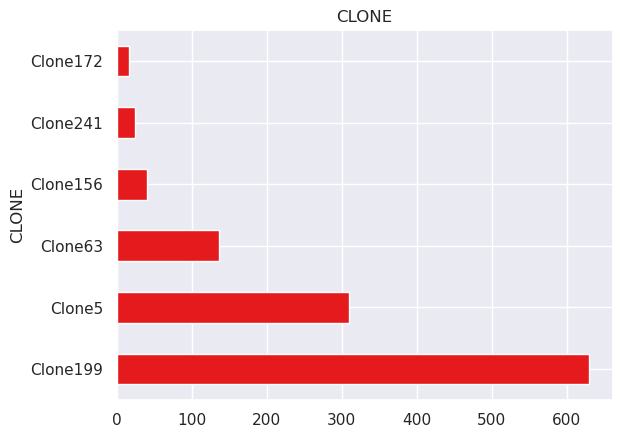

CLONE
Clone199    630
Clone5      310
Clone63     136
Clone156     41
Clone241     24
Clone172     17
Name: count, dtype: int64

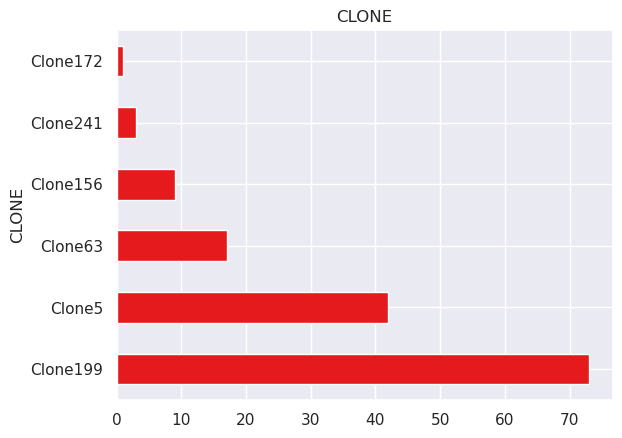

CLONE
Clone199    73
Clone5      42
Clone63     17
Clone156     9
Clone241     3
Clone172     1
Name: count, dtype: int64

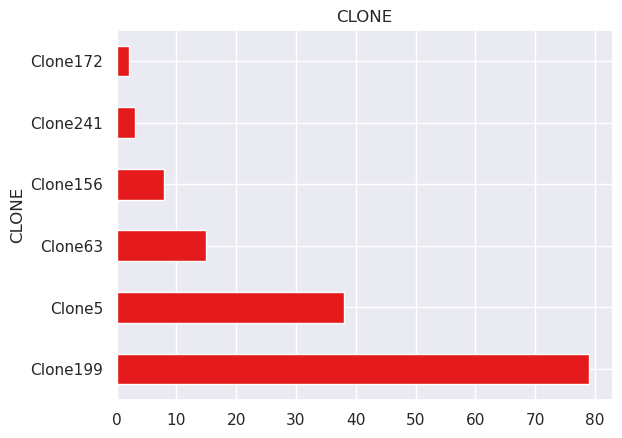

CLONE
Clone199    79
Clone5      38
Clone63     15
Clone156     8
Clone241     3
Clone172     2
Name: count, dtype: int64

,X.CHR,START,END,NORM_COUNT,COUNT,RDR,A_COUNT,B_COUNT,BAF,CLUSTER,CN_STATE,CLONE
CELL,,,,,,,,,,,,
AAATGCCCAGCCCATG,chr1,0,5000000,2654972,994,1.162660,46,9,0.163636,3,2|1,Clone199
AACCATGGTCAGAAGC,chr1,0,5000000,2654972,1822,0.952587,54,55,0.504587,3,1|1,Clone5
AACCATGGTTTGTCTT,chr1,0,5000000,2654972,1551,0.800833,65,34,0.343434,3,2|1,Clone156
AACTCAGTCCTCAGTC,chr1,0,5000000,2654972,1261,0.889142,62,34,0.354167,3,2|1,Clone199
AACTCCCCACGATAGG,chr1,0,5000000,2654972,1116,0.934572,59,15,0.202703,3,2|1,Clone199


In [132]:
dm.train_set.data_frame['CLONE'] = dm.train_set.data_frame['CLONE'].astype(str)
lbl, lbl_idx = np.unique(dm.train_set.data_frame.CLONE, return_index=True)
print(lbl, lbl_idx)

for frame in [dm.train_set.data_frame, dm.validation_set.data_frame, dm.test_set.data_frame]:
    
    # print("***", frame['CLONE'].isna().sum())
    frame = frame.groupby(frame.index).first()
    for col_key in ["CLONE"]:
        frame[col_key].value_counts().plot(kind = 'barh')
        plt.title(col_key)
        plt.show()
    
    display(frame[col_key].value_counts())

display(frame.head())


## Collect training, validation, and test features and labels

In [133]:
cluster_names = ["I", "II", "III", "IV", "V", "VI"]
print(cluster_names)

data, counts = [], []
for set_name, loader in zip(["Train", "Validation", "Test"], [dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()]):
    print("\n" + set_name + " set \n" + "="*(len(set_name) + 4))
    print(len(dm.train_dataloader()), len(dm.val_dataloader()), len(dm.test_dataloader()))
    # Combine batches
    features, labels = [], []
    for batch in iter(loader):
        print(batch["label"])
        features.append(batch["CNA"])
        labels.append(batch["label"])
    data.append({"CNA": torch.concat(features, 0).numpy().reshape((-1, 2, 22, 256)),
                 "label": torch.concat(labels, 0).numpy()}
               )
    
    # Report count of each clone 
    print(f"{data[-1]['CNA'].shape[0]} samples composed of")
    count = []
    for lbl, cnt in zip(*np.unique(data[-1]['label'], return_counts=True)):
        print(f"{cluster_names[lbl]} with count {cnt}")
        count.append(cnt)
    counts.append(count)

['I', 'II', 'III', 'IV', 'V', 'VI']

Train set 
37 5 5
tensor([4, 0, 0, 4, 4, 0, 4, 1, 4, 4, 4, 0, 1, 1, 3, 4, 4, 4, 4, 4, 0, 0, 0, 4,
        2, 4, 0, 1, 0, 4, 0, 4])
tensor([4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 2, 4, 1, 4, 4, 4, 4,
        4, 0, 0, 4, 1, 4, 4, 4])
tensor([4, 0, 4, 1, 2, 4, 4, 4, 4, 4, 1, 0, 4, 1, 1, 4, 0, 4, 0, 0, 5, 4, 1, 4,
        1, 1, 4, 0, 4, 0, 1, 4])
tensor([4, 1, 1, 4, 0, 0, 4, 1, 0, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 1, 4, 0, 4,
        0, 4, 4, 4, 4, 0, 0, 0])
tensor([4, 4, 0, 4, 4, 4, 1, 4, 0, 2, 4, 0, 0, 0, 4, 2, 0, 4, 4, 4, 0, 3, 2, 4,
        2, 0, 5, 4, 0, 1, 2, 0])
tensor([4, 0, 4, 4, 4, 4, 0, 4, 0, 4, 4, 0, 4, 4, 1, 0, 4, 1, 2, 4, 0, 0, 0, 4,
        0, 0, 0, 3, 4, 0, 0, 4])
tensor([4, 4, 4, 0, 4, 4, 2, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 0, 4, 4, 1, 0, 4, 4,
        1, 3, 4, 2, 4, 4, 1, 0])
tensor([4, 4, 4, 0, 1, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 2, 0, 4, 0, 4, 0, 1,
        2, 4, 4, 4, 4, 0, 1, 1])
tensor([4, 4, 0, 4, 2, 0, 4, 0, 0, 4, 3, 

# Section 1: Visualisation of CNA data

Select which data set we want to visualise in this section of the notebook, and which chromosome and strand to highlight.

     

In [134]:
subset = 0           # 0=train set, 1=validation set, 2=test set
chromosome = 17      # 1,...,22
strand = 2           # 1=major or 2=minor

Define plotting functions

In [135]:
def plot_chromosomes(features, 
                     xlabel="Chromosomes",
                     ylabel="Clone samples",
                     splits=None, 
                     figsize=(15,5)):

    fshape = features.shape
    features = features.reshape((fshape[0], -1))
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(features, 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
        
    # Vertical lines: indicating which chromosome we are zooming into in third plot
    for _chrom in range(1, 23):
        plt.axvline(x=(_chrom-1)*fshape[-1], color='k', alpha=0.25)
    # Horizontal lines: separating clones
    if splits is not None:
        for split in splits:
            plt.axhline(y=split, color='k', linestyle='-')
        ax.set_yticks((splits[1:] + splits[:-1])/2)
        ax.set_yticklabels(["I", "II", "III", "IV", "V", "VI"])
        
    plt.ylabel(ylabel)
    # X-axis
    ax.set_xticks([ (_chrom+0.5) * fshape[-1] for _chrom in range(22)])
    ax.set_xticklabels([_chrom for _chrom in range(1,23)], rotation=0)
    plt.xlabel(xlabel)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0, 8))
    colorbar.minorticks_off() 
    colorbar.set_ticklabels([i for i in range(8)])
    
def plot_chromosome(features, 
                    xlabel="Loci",
                    ylabel="Clone samples",
                    splits=None, 
                    figsize=(8,5)):

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(features, 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
        
    # Horizontal lines: separating clones
    if splits is not None:
        for split in splits:
            plt.axhline(y=split, color='k', linestyle='-')
        ax.set_yticks((splits[1:] + splits[:-1])/2)
        ax.set_yticklabels(["I", "II", "III", "IV", "V", "VI"])
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0, 8))
    colorbar.minorticks_off() 
    colorbar.set_ticklabels([i for i in range(8)])


## Plot chosen set, and zoom in on a selected chromosome and strand

* Clone I, a diploid clone comprised of mostly normal cells, is clearly distinguishable.
* Clone II, distinguished from V by not having an additional insertion on chromosome 3 of the minor strand
* Clone III, distinguished from V by an insertion on chromosome 2 of the minor strand
* Clone IV, distinguished from V by an insertion on chromosome 2 on the major strand
* Clone V, see others
* Clone VI is distinguuished from V by either an additioanl deletion on chromosome 3 of the major strand, or an additional insertion on chromosome 3 of the minor strand. 

(1158, 2, 22, 256)


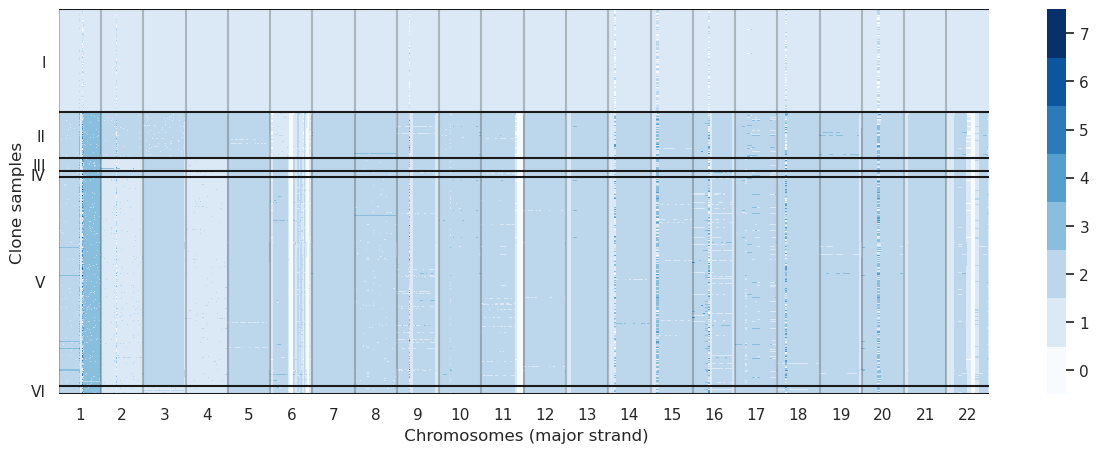

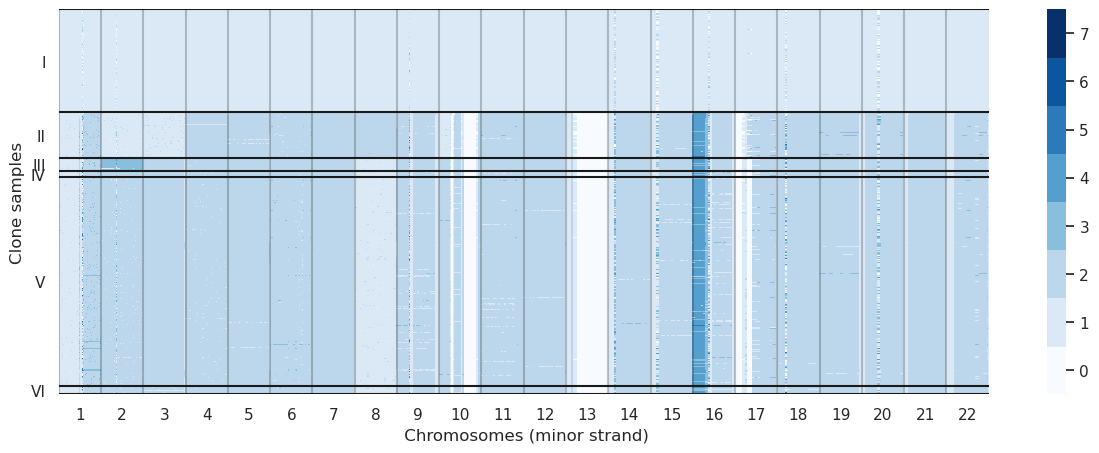

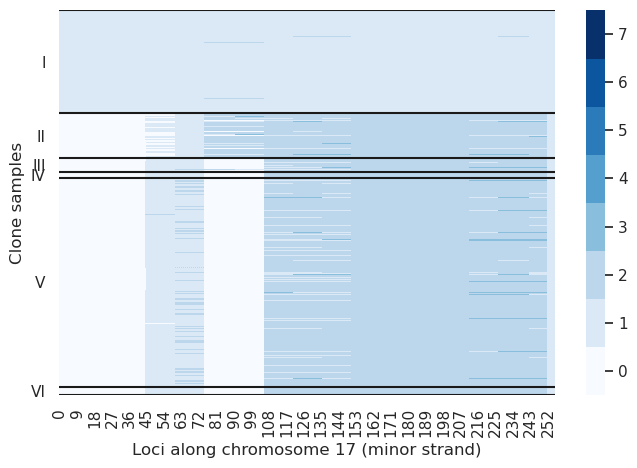

In [136]:
label_order = np.argsort(data[subset]["label"])
splits = np.insert(np.cumsum(counts[subset]), 0, 0)

print(data[subset]["CNA"].shape)

# All chromosomes
for _strand in range(1,3):
    features = data[subset]["CNA"][label_order, _strand-1, :, :]
    
    plot_chromosomes(features, 
                     splits=splits,
                     xlabel=f" Chromosomes ({'major' if _strand == 1 else 'minor'} strand)"
                    )
    plt.savefig(f"figs/{'Major' if _strand == 1 else 'Minor'}Strand.png", dpi=200, format='png', transparent=False)
    
    
# Single chromosome
plot_chromosome(data[subset]["CNA"][label_order, strand-1, chromosome-1, :],
                splits=splits,
                xlabel=f"Loci along chromosome {chromosome} ({'major' if strand == 1 else 'minor'} strand)")
plt.savefig(f"figs/{'Major' if _strand == 1 else 'Minor'}Strand_Chr{chromosome}.png", dpi=200, format='png', transparent=False)


## Plot the first k of each clone (for visual clarity due to class imbalance)

In the validation and test set there are few occurrences of the rare clusters, so we plot min(N,k) where N is the number of occurrences 

In [137]:
k = 10     # maximum number of samples to observe in each clone

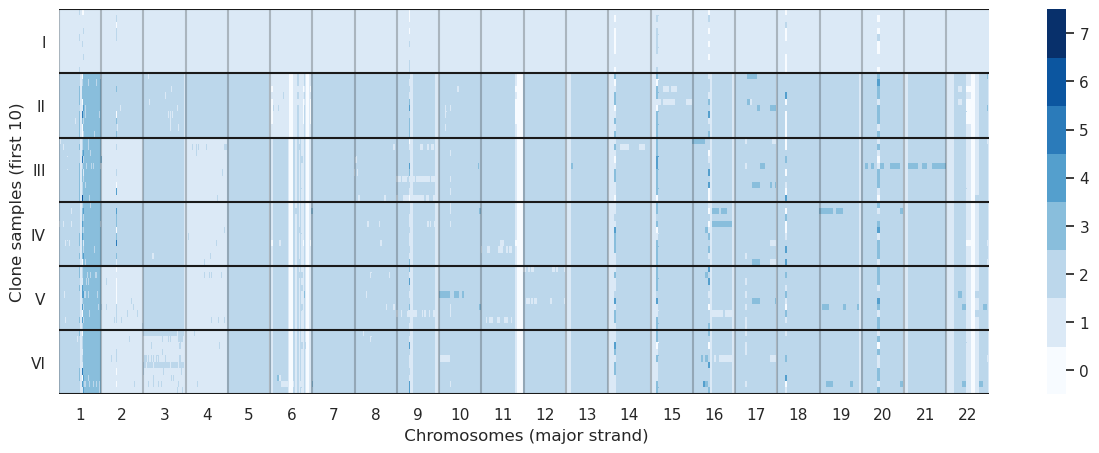

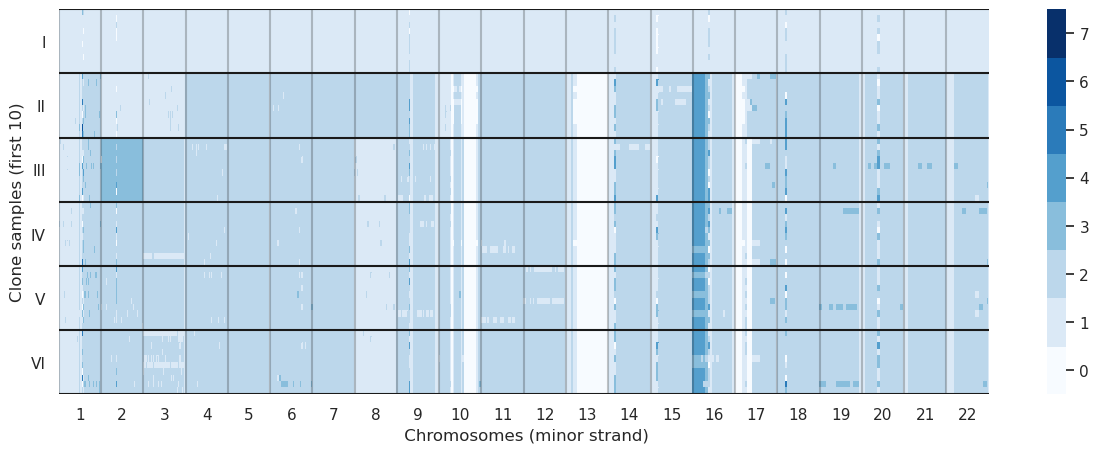

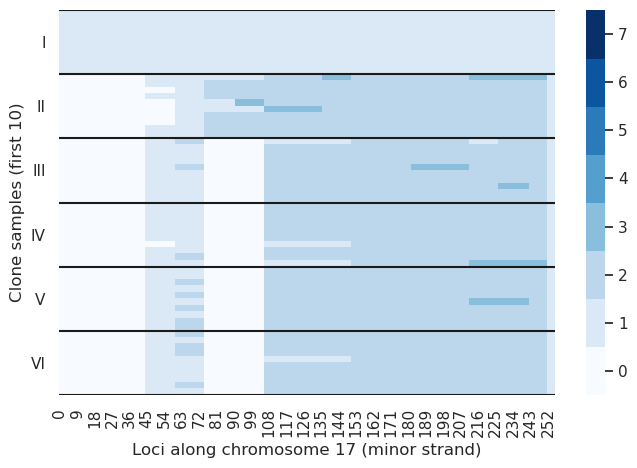

In [138]:
top_k = []
for clone in range(6):
    idx_top = np.where(data[subset]["label"] == clone)[0]
    _k = np.min((idx_top.shape[0], k))
    top_k.append(idx_top[:_k])
top_6k = np.concatenate(top_k, 0)
splits = np.insert(np.cumsum([len(_k) for _k in top_k]), 0, 0)

# All chromosomes
for _strand in range(1,3):
    features = data[subset]["CNA"][top_6k, _strand-1, :, :]
    plot_chromosomes(features, splits=splits, 
                     xlabel=f" Chromosomes ({'major' if _strand == 1 else 'minor'} strand)",
                     ylabel=f"Clone samples (first {k})")
    plt.savefig(f"figs/{'Major' if _strand == 1 else 'Minor'}Strand_top{k}.png", dpi=200, format='png', transparent=False)

# Single chromosome
plot_chromosome(data[subset]["CNA"][top_6k, strand-1, chromosome-1, :], 
                splits=splits, 
                xlabel=f"Loci along chromosome {chromosome} ({'major' if strand == 1 else 'minor'} strand)",
                ylabel=f"Clone samples (first {k})")
plt.savefig(f"figs/{'Major' if _strand == 1 else 'Minor'}Strand_Chr{chromosome}_top{k}.png", dpi=200, format='png', transparent=False)


# Model visualisations

Additional visualisation are provided at run-time with WandB logging callbacks.

Replace log file to view the same plots for other model types

In [152]:
# load from checkpoint
%env SLURM_NTASKS_PER_NODE=28      

model = AttentiveAutoEncoder.load_from_checkpoint(f"./{checkpoint}.ckpt")

model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# create a callback that will save meta outputs
test_data = stack_batches(dm.test_dataloader)
save_output = SaveOutput(test_samples=test_data,
                         file_path=f"{checkpoint}-tmp.ckpt"
                         )

# and reproduce the reported results
trainer = pl.Trainer(callbacks=[save_output], logger=None, gpus=1 if torch.cuda.is_available() else 0)   # save_output
trainer.test(model, dataloaders=dm.test_dataloader())

env: SLURM_NTASKS_PER_NODE=28
{'D': 3, 'wavelet': 'haar', 'J': 8, 'layers': 1, 'hidden_channels': 256, 'proj_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([32, 2, 5632])
torch.Size([32, 2, 5632])
torch.Size([32, 2, 5632])
torch.Size([32, 2, 5632])
torch.Size([32, 2, 5632])
torch.Size([32, 2, 5632])
torch.Size([32, 2, 5632])
torch.Size([32, 2, 5632])
torch.Size([17, 2, 5632])
torch.Size([17, 2, 5632])
torch.Size([145, 2, 5632])
torch.Size([145, 2, 5632])


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05941953510046005    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.05941953510046005}]

In [153]:
with open(f"{checkpoint}-tmp.ckpt", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
lbls = meta_results["labels"].cpu().numpy()
M = meta_results["M"]
Mbar = np.mean(meta_results["M"], axis=1)
Mflat = meta_results["M"].reshape(meta_results["M"].shape[0], -1)
A = meta_results["attention"]

print(f"Available outputs: {[i for i in meta_results.keys()]}")

Available outputs: ['masked_inputs', 'masked_targets', 'masked_targets_tensor', 'resolution_embeddings', 'attention', 'M', 'masked_predictions', 'labels']


## Section 2.1: Visualise Wave-LSTM encoder output

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

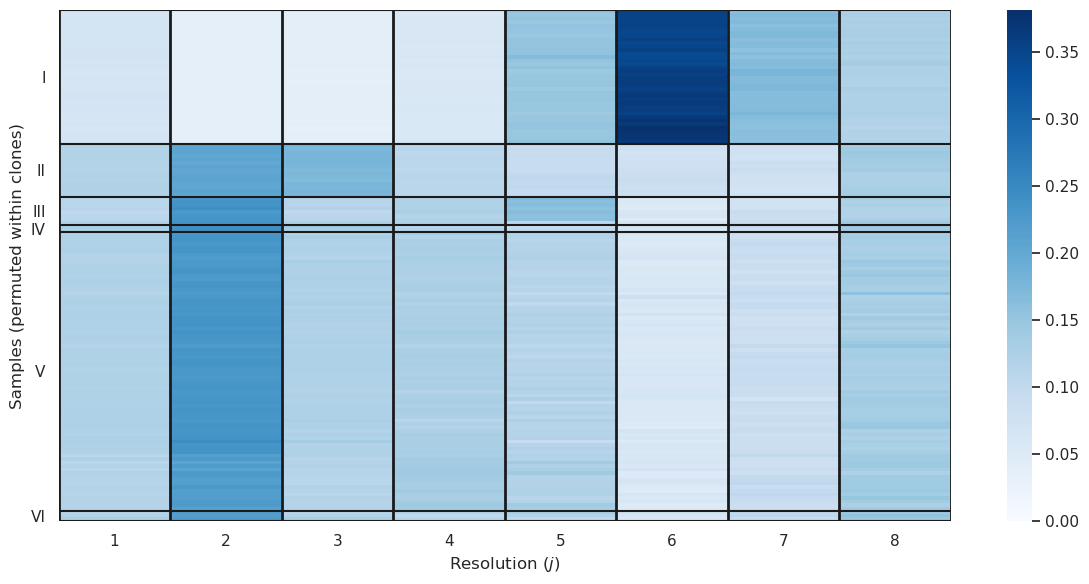

In [154]:
# Arguments
num_clusters = [3, 2, 1, 1, 2, 2]                    # The number of sub-clusters to split each clone into    

Abar = np.mean(A, axis=1)

# Nested ordering (by biclustering attention)
atn_order = []
for idx_clone in range(6):
    lbl_idx = np.where(data[-1]["label"] == idx_clone)[0]
    if len(lbl_idx) > 1:
        atn_clone = Abar[lbl_idx, :]
        clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=np.min((num_clusters[idx_clone], atn_clone.shape[0])))
        clustering.fit(atn_clone)
        permute_idx = np.argsort(clustering.labels_)
        atn_order.append(lbl_idx[permute_idx])
    else:
        atn_order.append(lbl_idx)
atn_order = np.concatenate(atn_order)

# Make permuted attention plot
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.heatmap(Abar[atn_order, :], ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1
# Split clones
splits = np.insert(np.cumsum(counts[-1]), 0, 0)
for split in splits:
    plt.axhline(y=split, color='k', linestyle='-')
ax.set_yticks((splits[1:] + splits[:-1])/2)
ax.set_yticklabels(cluster_names)
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)    
# Split resolutions
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick, ymin=0, ymax=Abar.shape[0], linewidth=2, color='k')
ax.vlines(x=Abar.shape[1], ymin=0, ymax=Abar.shape[0], linewidth=2, color='k')
# 
ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Samples (permuted within clones)")    # permuted
plt.ylim((splits[-1], 0, ))
plt.tight_layout()
plt.savefig(f"figs/{checkpoint}_attention.png", dpi=200, format='png', transparent=False)

## Visualise test features, permuted by attention

Plot test CNA features, permuted by the same order as attention above

Select which chromosome and strand to highlight, and whether we view the true test data or (the noise filtered) reconstruction. Viewing the less noisy reconstruction is recommended for any initial exploration.

In [155]:
chromosomes = [6, 22, 17]        # 1,...,22
strands = [1, 1, 2]              # major=1, or minor=2
assert len(chromosomes) == len(strands)
view_reconstruction = False

/tmp/ipykernel_22294/3553731767.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


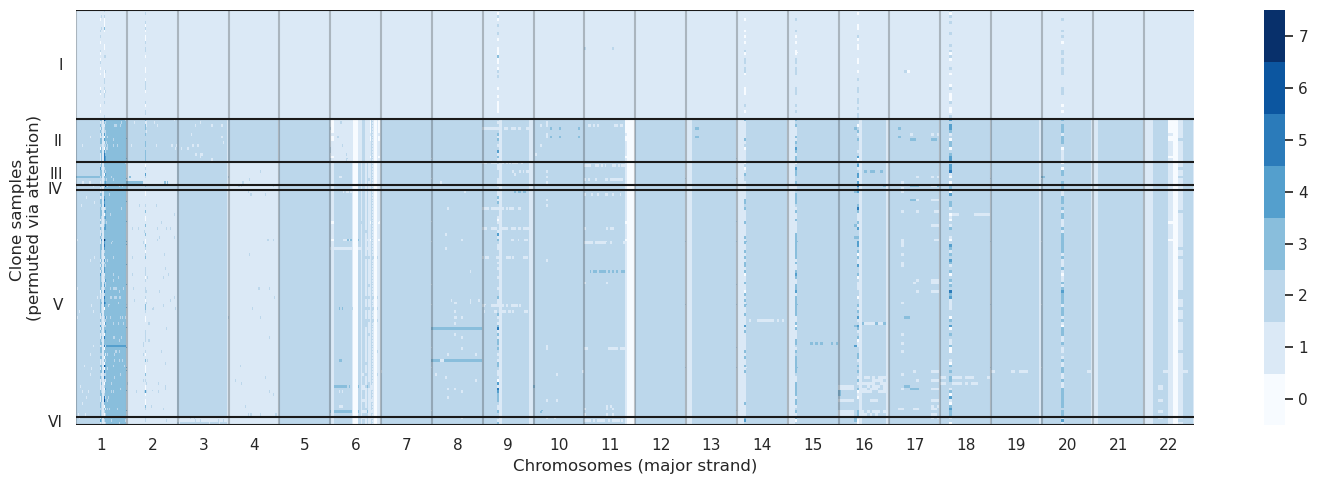

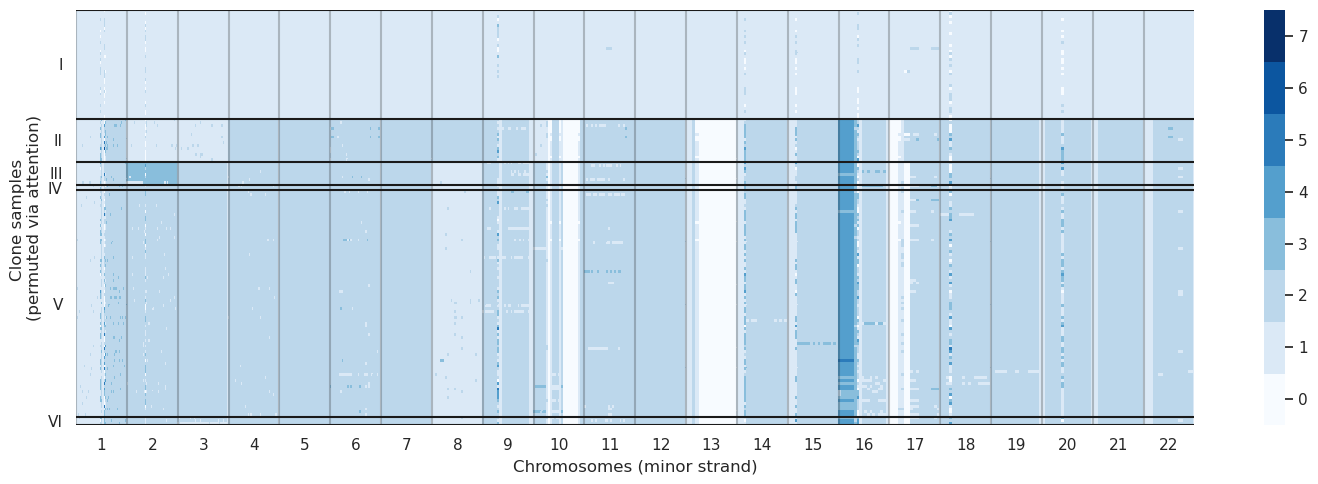

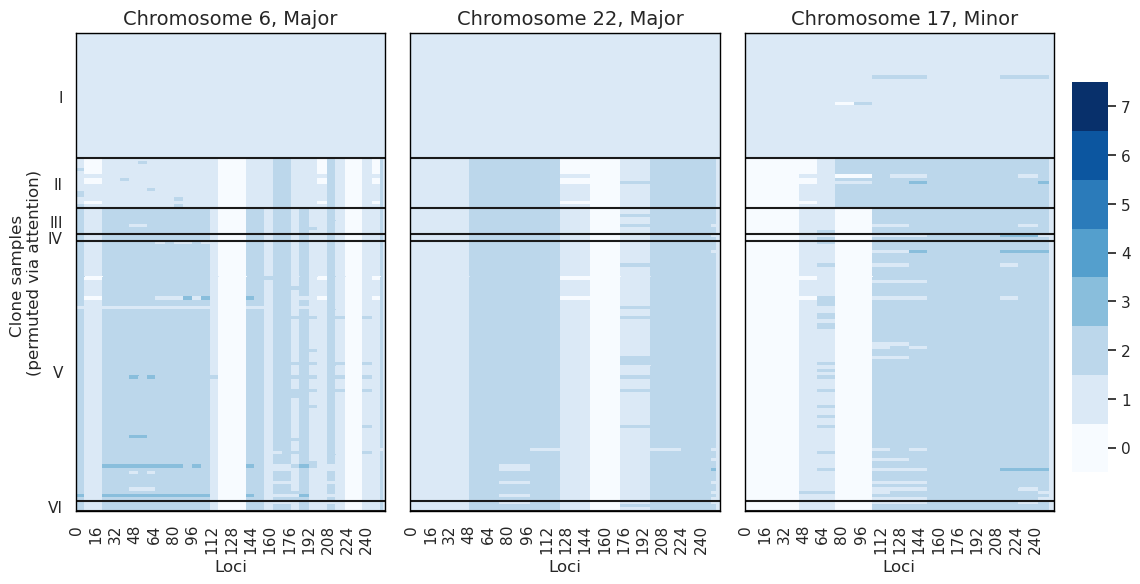

In [156]:
if view_reconstruction:
    test_features = meta_results["masked_predictions"][0].reshape(-1,2,22,256)
    norm_mu, norm_std = np.mean(data[0]["CNA"], axis=0), np.std(data[0]["CNA"], axis=0)
    test_features *= norm_std
    test_features += norm_mu
else:
    test_features = data[-1]["CNA"]

splits = np.insert(np.cumsum(counts[-1]), 0, 0)    

# Stacked channels
for _strand in range(1,3):
    
    plot_chromosomes(test_features[atn_order, _strand-1, :, :],
                    splits=splits,
                    xlabel=f"Chromosomes ({'major' if _strand == 1 else 'minor'} strand)",
                    ylabel="Clone samples \n(permuted via attention)",
                    )
    plt.tight_layout()
    plt.savefig(f"figs/{checkpoint}_Strand{'Major' if _strand == 1 else 'Minor'}_PermuteAttention.png", dpi=200, format='png', transparent=False)
    
    
# Zoom in
fig, axes = plt.subplots(1, len(chromosomes), figsize=(12,6), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.9, .2, .03, .65])
for idx, ax in enumerate(axes):
    sns.heatmap(test_features[atn_order, strands[idx]-1, chromosomes[idx]-1, :], ax=ax, cmap=cmap, norm=norm, yticklabels=True, 
                cbar=idx == len(strands)-1, cbar_ax=cbar_ax if idx == len(strands)-1 else None)

    # Horizontal lines: separating sub-clusters
    for split in splits:
        ax.axhline(y=split, color='k', linestyle='-')
    
    # X-axis
    ax.set_xlabel(f"Loci")
    ax.set_xlim((0,256))
    # Manually specify colorbar labelling after it's been generated
    if idx == len(strands)-1:
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.arange(0, 8))
        colorbar.minorticks_off() 

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.text(.15, 1.05, f"Chromosome {chromosomes[idx]}, {'Major' if strands[idx]-1 == 0 else 'Minor'}", ha='left', va='top', transform=ax.transAxes, size=14)
 
# Y-axis
axes[0].set_yticks((splits[1:] + splits[:-1])/2)
axes[0].set_yticklabels(["I", "II", "III", "IV", "V", "VI"])
axes[0].set_ylabel(f"Clone samples \n(permuted via attention)", loc="center")

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(f"figs/{checkpoint}_Strand{'Major' if _strand == 1 else 'Minor'}_PermuteAttention_SubClonalsII.png", dpi=200, format='png', transparent=False)

## Visualise resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

Create reducer. 

Note, there is a large imbalance in representation so the perplexity must be chosen to compromise between preserving local structures for under represented clones and the global structures of the larger clones.

In [157]:
# First, just create instance of whatever reducer we want to use throughout
reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP(n_neighbors=15)
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=4)
else:
    raise NotImplementedError

# axis labels
proj1_label = f"{reduce_method}-1"
proj2_label = f"{reduce_method}-2"

In [158]:
data_res_emb = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res]
    x_j = meta_results["masked_inputs"][j_res]

    # Projection of scale embeddings, and source separated input
    for val, val_name in zip([h_j, x_j], ["m_j", "X_j"]):
        
        val = val.reshape((val.shape[0], -1))           # Reshape x_j to flatten channels
        val = StandardScaler().fit_transform(val)       # Scale before any transform
        
        embedding = reducer.fit_transform(val)
        for i in range(embedding.shape[0]):
            data_res_emb.append([i, 
                                 embedding[i, 0], embedding[i, 1], 
                                 val_name,
                                 j_name, cluster_names[data[-1]["label"][i]],
                                ])  

df_res_emb = pd.DataFrame(data_res_emb, columns=["sample", proj1_label, proj2_label, "source", "resolution", "Clone"])
display(df_res_emb)

,sample,tSNE-1,tSNE-2,source,resolution,Clone
0,0,9.054912,-41.602097,m_j,1,V
1,1,-28.745064,15.598751,m_j,1,I
2,2,1.600226,8.064178,m_j,1,III
3,3,39.525959,-9.896259,m_j,1,V
4,4,-22.774677,-27.767942,m_j,1,V
...,...,...,...,...,...,...
2315,140,-7.054457,45.798347,X_j,8,I
2316,141,-6.781562,-26.215559,X_j,8,V
2317,142,-12.188631,48.051929,X_j,8,I
2318,143,16.274208,-24.561155,X_j,8,V


Choose which subset to view

In [159]:
if stack:
    resolutions = [1,3,5,8]                           # 1,..., J
else:
    resolutions = [1,2,3,4]                           # 1,..., J

sources = ["X_j", "m_j"]                          # Source separated input and/or resolution embeddings
clones = ["I", "II", "III", "IV", "V", "VI"]      # Choose to zoom into clones

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:37                                                                                   │
│                                                                                                  │
│   34                                                                                             │
│   35 # Adjust margins                                                                            │
│   36 plt.tight_layout()                                                                          │
│ ❱ 37 g.figure.subplots_adjust(wspace=0.03, hspace=0.03)                                          │
│   38                                                                                             │
│   39 plt.savefig(f"figs/{checkpoint}_ResolutionEmbeddings.png", dpi=200, format='png', transp    │
│   40                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'FacetGrid' object has no attribute 'figure'

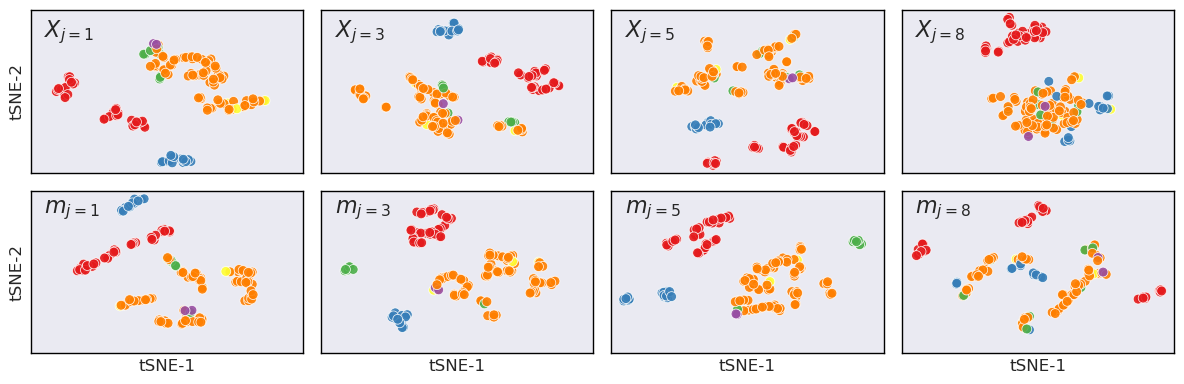

In [160]:
# Plot 
df_fig2 = df_res_emb[df_res_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
df_fig2 = df_fig2[df_fig2["Clone"].isin(clones)]           # Zoom into subset of classes
# display(df_fig2)

g = sns.relplot(data=df_fig2, x=proj1_label, y=proj2_label,  row="source", col="resolution", hue="Clone", hue_order=clones,
                row_order=sources,
                legend=False, s=50, alpha=0.9,
                height=2, aspect=1.5,
                palette="Set1",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True)
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True)

spaces = []
tmp1 = r"_{j="
tmp2 = r"}"
[[ spaces.append(f"${i[0]}{tmp1}{j}{tmp2}$") for j in resolutions] for i in sources] 
for ax, space in zip(g.axes.flatten(), spaces ):  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    # ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, f'{space}', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
        
plt.savefig(f"figs/{checkpoint}_ResolutionEmbeddings.png", dpi=200, format='png', transparent=False)

We find that $h_j$ benefits from the information flow through the LSTM model. Embeddings are improved by

* the additional label/task information, leading to adaptive filtering.
* the ability of the LSTM model to pass information through the recurrent cell states. E.g. Whilst the orange class was separable at $X_{j=4}$, and subsequently not - within the resolution embeddings that information has been retained for $h_{j\geq4}$. Note, this behaviour can be controlled through reducing and increasing the capacity of the hidden states.

We can view all of the resolution embeddings

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:42                                                                                   │
│                                                                                                  │
│   39                                                                                             │
│   40 # Adjust margins                                                                            │
│   41 plt.tight_layout()                                                                          │
│ ❱ 42 g.figure.subplots_adjust(wspace=0.03, hspace=0.03)                                          │
│   43 # plt.gcf().set_size_inches(8, 3.5)                                                         │
│   44                                                                                             │
│   45 plt.savefig(f"figs/{checkpoint}_ResolutionEmbeddings_{sources[0]}.png", dpi=200, format=    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'FacetGrid' object has no attribute 'figure'

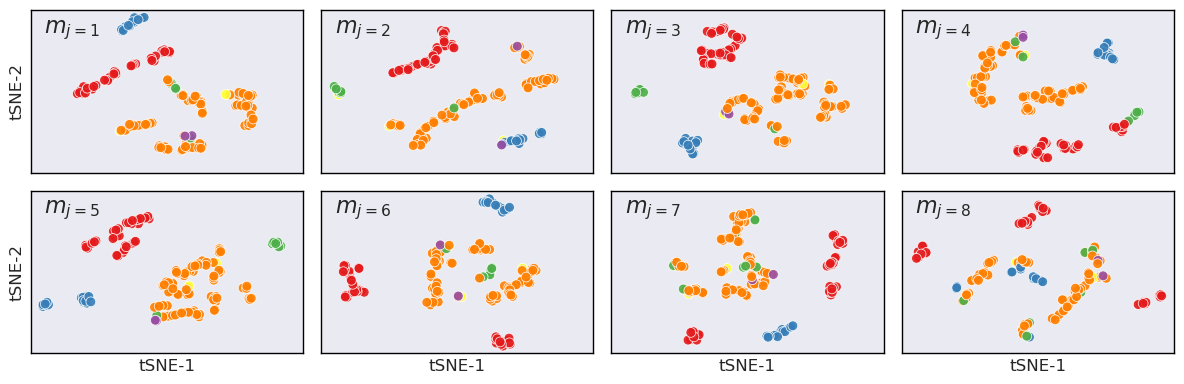

In [161]:
# Wrapped version of the above, for _either_ source separated input or resolution embedding
resolutions = [_ for _ in range(1,9)] 
sources = ["m_j"]  # "X_j",
clones = ["I", "II", "III", "IV", "V", "VI"]

# Plot 
df_fig2 = df_res_emb[df_res_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
df_fig2 = df_fig2[df_fig2["Clone"].isin(clones)]
# display(df_fig2)

g = sns.relplot(data=df_fig2, x=proj1_label, y=proj2_label,  col="resolution", hue="Clone", hue_order=clones,
                col_wrap=4,
                legend=False, s=50, alpha=0.9,
                height=2, aspect=1.5,
                palette="Set1",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True)
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True)

spaces = []
tmp1 = r"_{j="
tmp2 = r"}"
[[ spaces.append(f"${i[0]}{tmp1}{j}{tmp2}$") for j in resolutions] for i in sources] 
for ax, space in zip(g.axes.flatten(), spaces ):  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    # ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, f'{space}', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.gcf().set_size_inches(8, 3.5)
        
plt.savefig(f"figs/{checkpoint}_ResolutionEmbeddings_{sources[0]}.png", dpi=200, format='png', transparent=False)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

In [162]:
Mbar = np.mean(M, axis=1).reshape((M.shape[0], -1))

# Construct dataframe
data_mres_emb = []
embedding = reducer.fit_transform(Mbar)
for i in range(embedding.shape[0]):
    data_mres_emb.append([i,
                          embedding[i, 0], embedding[i, 1], 
                          "Mbar",
                          cluster_names[data[-1]["label"][i]]
                         ])  
df_mres_emb = pd.DataFrame(data_mres_emb, columns=["sample", proj1_label, proj2_label, "source", "Clone"])
display(df_mres_emb.head())

,sample,tSNE-1,tSNE-2,source,Clone
0,0,-37.010990,3.696876,Mbar,V
1,1,50.561253,-6.153066,Mbar,I
2,2,-8.978270,56.655651,Mbar,III
3,3,6.493016,11.127344,Mbar,V
4,4,-36.424252,-4.344572,Mbar,V


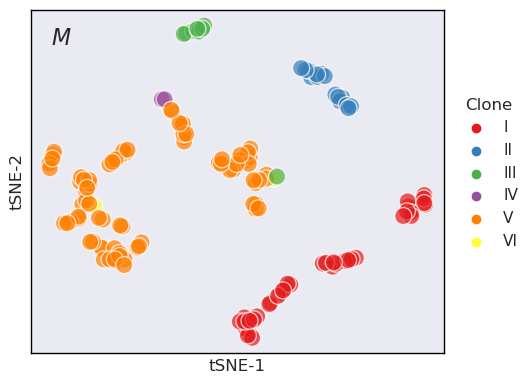

In [163]:
# df_mres_emb = df_mres_emb[df_mres_emb["Clone"].isin(["Clone I"])]           # Zoom into subset of classes

g = sns.relplot(data=df_mres_emb, x=proj1_label, y=proj2_label,  col="source", hue="Clone", hue_order=clones,
                row_order=sources,
                legend=True, s=150, alpha=0.7,
                height=4, aspect=1,
                palette="Set1",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")

leg = g._legend
leg.set_bbox_to_anchor([0.95, 0.75])
leg._loc = 2 

g.set_titles(col_template="", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=proj1_label, clear_inner=True)
g.set_ylabels(label=proj2_label, clear_inner=True)

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    # ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, r'$M$', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
        
plt.savefig(f"figs/{checkpoint}_MultiResolutionEmbedding.png", dpi=200, format='png', bbox_inches='tight', transparent=False)

## How clusters in resolution space look in feature space

i.e. what features are certain resolutions making distinctions upon.

/tmp/ipykernel_22294/1359492333.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


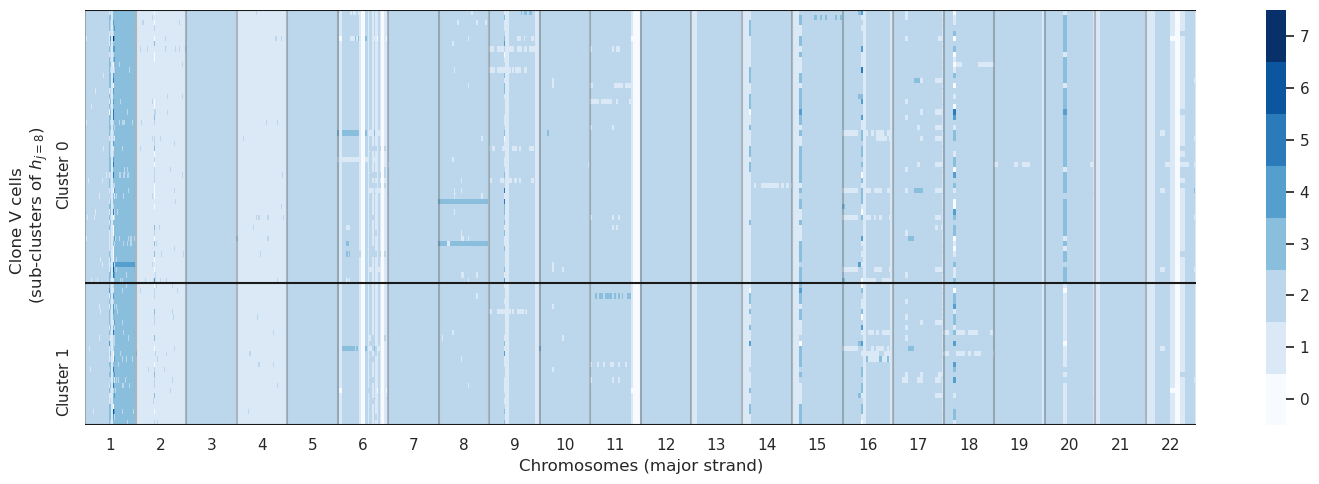

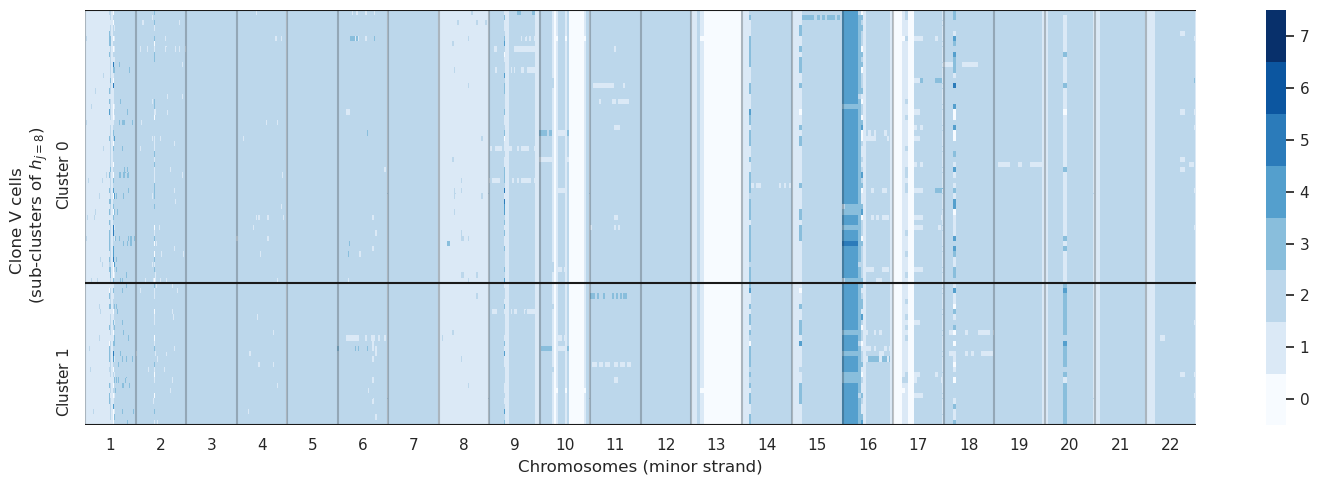

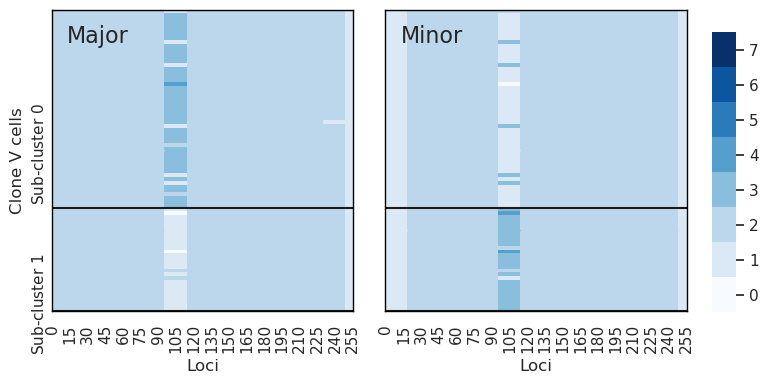

In [164]:
# Which latent space we wish to visualise
j = 8 if stack else 4
clone = "V"
num_clusters = 2

# Which strand and chromosome to zoom into
chromosomes = [20]    # [_ for _ in range(23)]

df_res_emb_cluster = df_res_emb[(df_res_emb["source"]=="m_j") & 
                                (df_res_emb["Clone"]==clone) & 
                                (df_res_emb["resolution"] == str(j))
                                 ]
features = data[-1]["CNA"][df_res_emb_cluster["sample"], :, :, :]
# display(df_res_emb_cluster)

clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters)
clustering.fit(df_res_emb_cluster[[proj1_label, proj2_label]])
permute_idx = np.argsort(clustering.labels_)
sub_counts = [len(np.where(clustering.labels_==i)[0]) for i in range(num_clusters)]

# Stacked channels
for _strand in range(1,3):
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    sns.heatmap(features[permute_idx, _strand-1, :, :].reshape((-1, 22*256)), 
                ax=ax, cmap=cmap, norm=norm, yticklabels=False,
               ) 
    # Vertical lines: indicating which chromosome we are zooming into in third plot
    for _chrom in range(1, 23):
        plt.axvline(x=(_chrom-1)*256, color='k', alpha=0.25)
    # Horizontal lines: separating sub-clusters
    splits = np.insert(np.cumsum(sub_counts), 0, 0)
    for split in splits:
        plt.axhline(y=split, color='k', linestyle='-')
    # Label y-axis
    ax.set_yticks((splits[1:] + splits[:-1])/2)
    ax.set_yticklabels([f"Cluster ${_i}$" for _i in range(num_clusters)], rotation=90)
    plt.ylim((len(permute_idx), 0, ))
    plt.ylabel(f"Clone {clone} cells \n (sub-clusters of $h{tmp1}{j}{tmp2}$)")
    # X-axis
    ax.set_xticks([ (_chrom+0.5) * 256 for _chrom in range(22)])
    ax.set_xticklabels([_chrom for _chrom in range(1,23)], rotation=0)
    plt.xlabel(f"Chromosomes ({'major' if _strand == 1 else 'minor'} strand)")
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(0, 8))
    colorbar.set_ticklabels([i for i in range(8)])
    colorbar.minorticks_off() 
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"figs/{checkpoint}_Clone{clone}_{num_clusters}Subclusters_hj{j}_strand{_strand}.png", dpi=200, format='png', transparent=False)   
            
for chromosome in chromosomes:        
    # Zoom in
    fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.9, .2, .03, .7])
    splits = np.insert(np.cumsum(sub_counts), 0, 0)
    for strand, ax in enumerate(axes):
        sns.heatmap(features[permute_idx, strand, chromosome-1, :], ax=ax, cmap=cmap, norm=norm, yticklabels=True, 
                    cbar=strand == 0, cbar_ax=None if strand else cbar_ax)
        # Horizontal lines: separating sub-clusters
        for split in splits:
            ax.axhline(y=split, color='k', linestyle='-')
        # X-axis
        ax.set_xlabel(f"Loci")
        ax.set_xlim((0,256))
        # Manually specify colorbar labelling after it's been generated
        if not strand:
            colorbar = ax.collections[0].colorbar
            colorbar.set_ticks(np.arange(0, 8))
            colorbar.minorticks_off() 
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        ax.set_facecolor((0, 0, 0, 0))
        ax.text(.05, .95, f"{'Major' if strand == 0 else 'Minor'}", ha='left', va='top', transform=ax.transAxes, size=16)
    
    # # Y-axis
    axes[0].set_yticks((splits[1:] + splits[:-1])/2)
    axes[0].set_yticklabels([f"Sub-cluster ${_i}$" for _i in range(num_clusters)], rotation=90, fontdict={'horizontalalignment': "center"})   # \n (sub-clusters of $h{tmp1}{j}{tmp2}$)
    axes[0].set_ylabel(f"Clone {clone} cells", loc="center")
    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f"figs/{checkpoint}_Clone{clone}_{num_clusters}Subclusters_hj{j}_Chr{chromosome}.png", dpi=200, format='png', transparent=False)   

## TODO: add histogram plot back in (lost from corrupted file)